In [41]:
import torch
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImage,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

import matplotlib.pyplot as plt

In [42]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

from torch.utils.data import Dataset

class MRI_dataset(Dataset):
    def __init__(self, train_DIR_PATH=None, ext=None) -> None:
        super().__init__()
        assert train_DIR_PATH and ext, "pass a train data path and ext into 'train_DIR_PATH, 'ext"

        self.ext = ext
        self.train_SCAN_PATH = []
        self.transform = A.Compose([ToTensorV2()])

        folds = [os.path.join(train_DIR_PATH, fold) for fold in os.listdir(train_DIR_PATH) if os.path.isdir(os.path.join(train_DIR_PATH, fold))]
        for fold in folds:
            self.train_SCAN_PATH += [os.path.join(fold, sample_path) for sample_path in os.listdir(fold)]

    def __getitem__(self, index):
        return self.get_SCANS(self.train_SCAN_PATH[index])

    def __len__(self):
        return len(self.train_SCAN_PATH)
    
    def get_SCANS(self, path):

        img = path.split('/')[-1]

        seg   = os.path.join(path,f'{img}_seg.{self.ext}')
        flair = os.path.join(path,f'{img}_flair.{self.ext}')
        t1    = os.path.join(path,f'{img}_t1.{self.ext}')
        t1ce  = os.path.join(path,f'{img}_t1ce.{self.ext}')
        t2    = os.path.join(path,f'{img}_t2.{self.ext}')

        data_pathd = {
            'image': (t1, t1ce, t2, flair),
            'label': seg
        }

        data_d = LoadImaged(keys=["image", "label"])(data_pathd)

        if self.transform:
            data_d = self.transform(data_d)
        

        return data_d

    
    # def norm(self, nii_img, seg=False):

    #     img = nii_img.get_fdata()

    #     if seg: 
    #         # Make the label set from [0,1,2,4] to [0,1,2,3]
    #         img = np.array(img, dtype= np.int32)
    #         img[img==4] = 3
    #     else:
    #         # z-score norm per img
    #         img = np.array(img, dtype=np.float32)
    #         fore_mask = img != 0
    #         img[fore_mask] = (img[fore_mask] -  np.mean(img[fore_mask])) / np.std(img[fore_mask])
        
    #     return img

In [43]:
img_path = '/root/Competitions/Kaggle/BraST2020(MICCAI)/data/train/fold1/BraTS20_Training_001/BraTS20_Training_001_t1.nii'

loader = LoadImage(dtype=np.float32, image_only=True)
image = loader(img_path)
print(f"image shape: {image.shape}")
print(f"image affine:\n{image.meta['affine']}")
print(f"image pixdim:\n{image.pixdim}")

image shape: torch.Size([240, 240, 155])
image affine:
tensor([[ -1.,  -0.,  -0.,   0.],
        [ -0.,  -1.,  -0., 239.],
        [  0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   1.]], dtype=torch.float64)
image pixdim:
tensor([1., 1., 1.], dtype=torch.float64)


In [75]:
data_path_dict = {
    'image' : (img_path,'/root/Competitions/Kaggle/BraST2020(MICCAI)/data/train/fold1/BraTS20_Training_001/BraTS20_Training_001_t1.nii'),
    'label' : '/root/Competitions/Kaggle/BraST2020(MICCAI)/data/train/fold1/BraTS20_Training_001/BraTS20_Training_001_seg.nii'
}

loader = LoadImaged(keys=("image", "label"), image_only=False)
data_dict = loader(data_path_dict)
# print(f"input:, {train_data_dicts[0]}")
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image'].pixdim}")

image shape: torch.Size([2, 240, 240, 155])
label shape: torch.Size([240, 240, 155])
image pixdim:
tensor([1., 1., 1.], dtype=torch.float64)


In [76]:
image, label = data_dict['image'], data_dict['label']

ensure_channel_first = EnsureChannelFirstd(keys=["image", "label"])
datac_dict = ensure_channel_first(data_dict)


In [77]:
# class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
#     """
#     Convert labels to multi channels based on brats classes:
#     label 1 is the peritumoral edema
#     label 2 is the GD-enhancing tumor
#     label 3 is the necrotic and non-enhancing tumor core
#     The possible classes are TC (Tumor core), WT (Whole tumor)
#     and ET (Enhancing tumor).

#     """

#     def __call__(self, data):
#         d = dict(data)
#         for key in self.keys:
#             result = []
#             # merge label 2 and label 3 to construct TC
#             result.append(torch.logical_or(d[key] == 2, d[key] == 3))
#             # merge labels 1, 2 and 3 to construct WT
#             result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
#             # label 2 is ET
#             result.append(d[key] == 2)
#             d[key] = torch.stack(result, axis=0).float()
#         return d

In [78]:
# cvtmultiC = ConvertToMultiChannelBasedOnBratsClassesd(keys='label')
# print(np.unique(datac_dict['label']))
# datac_dict = cvtmultiC(datac_dict)
# print(np.unique(datac_dict['label']))
# print(datac_dict['label'].shape)


In [81]:
orientation = Orientationd(keys=["image", "label"], axcodes="PLI")
data_dict = orientation(datac_dict)
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image'].meta['affine']}")
print(f"label affine after Spacing:\n{data_dict['label'].meta['affine']}")

image shape: torch.Size([2, 240, 240, 155])
label shape: torch.Size([1, 240, 240, 155])
image affine after Spacing:
tensor([[   1.,    0.,    0., -239.],
        [   0.,    1.,    0.,    0.],
        [   0.,    0.,    1.,    0.],
        [   0.,    0.,    0.,    1.]])
label affine after Spacing:
tensor([[   1.,    0.,    0., -239.],
        [   0.,    1.,    0.,    0.],
        [   0.,    0.,    1.,    0.],
        [   0.,    0.,    0.,    1.]])


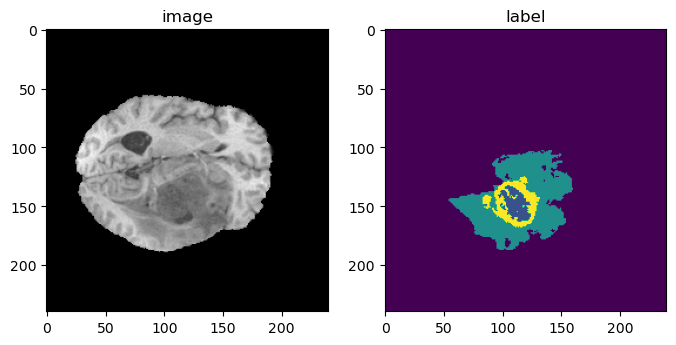

In [82]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 70], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 70])
plt.show()

In [66]:
spacing = Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"))
data_dict = spacing(data_dict)
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image'].meta['affine']}")
print(f"label affine after Spacing:\n{data_dict['label'].meta['affine']}")

image shape: torch.Size([2, 240, 240, 155])
label shape: torch.Size([1, 240, 240, 155])
image affine after Spacing:
tensor([[  0.,  -1.,   0.,   0.],
        [ -1.,   0.,   0., 239.],
        [  0.,   0.,  -1., 154.],
        [  0.,   0.,   0.,   1.]], dtype=torch.float64)
label affine after Spacing:
tensor([[  0.,  -1.,   0.,   0.],
        [ -1.,   0.,   0., 239.],
        [  0.,   0.,  -1., 154.],
        [  0.,   0.,   0.,   1.]], dtype=torch.float64)


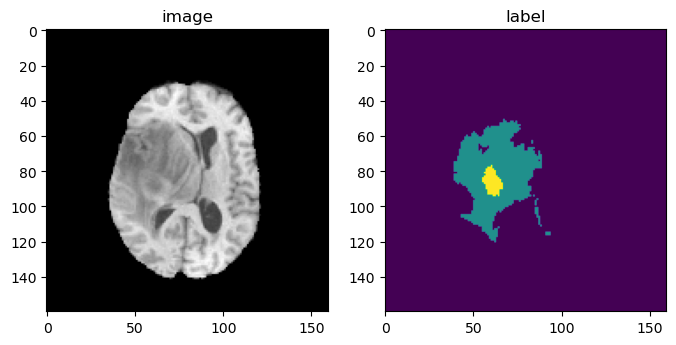

In [59]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 15], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 15])
plt.show()